In [1]:
%run Package_AND_Parameter.ipynb
%run Feature_Selection_Methods.ipynb
%run Smoothing.ipynb

C:\Users\vita7\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# READ TRAINING DATA

In [2]:
tr_df = pd.read_csv('Analysis_Dataframe.csv', header=[0,1], index_col=[0,1])
tr_df.index.names = ['epoch','condition']
tr_df.reset_index(level = 1,inplace = True)

train_X = tr_df.drop(columns=['condition'])
train_Y = tr_df['condition']
train_X.head()

C:\Users\vita7\Anaconda3\lib\site-packages\pandas\core\generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


Function   Variance                                                     \
Band     EEG Fpz-Cz EEG Fpz-Cz Delta EEG Fpz-Cz Theta EEG Fpz-Cz Alpha   
epoch                                                                    
2748      21.828373        18.494132         5.649302         2.428855   
2749      23.075825        22.760025         6.918420         2.337169   
2750      26.013966        23.630517         5.957379         2.165278   
2751      23.904033        22.933247         5.729646         2.354991   
2752      25.298234        23.799146         5.792871         2.322016   

Function                                                                 \
Band     EEG Fpz-Cz Sigma EEG Fpz-Cz Beta EEG Fpz-Cz DOR EEG Fpz-Cz TOR   
epoch                                                                     
2748             2.282368        3.455594       0.847252       0.258805   
2749             2.308580        3.580158       0.986315       0.299812   
2750             1.908565        3.032821       0.908378       0.229007   
2751             1.925690        3.263456       0.959388       0.239694   
2752             1.733728        2.915820       0.940743       0.228983   

Function                                ...  \
Band     EEG Fpz-Cz AOR EEG Fpz-Cz SOR  ...   
epoch                                   ...   
2748           0.111271       0.104560  ...   
2749           0.101282       0.100043  ...   
2750           0.083235       0.073367  ...   
2751           0.098519       0.080559  ...   
2752           0.091786       0.068532  ...   

Function First-order AutoCorrelation Coefficient                 \
Band                              EEG Fpz-Cz TDR EEG Fpz-Cz ADR   
epoch                                                             
2748                                    0.936464       0.816104   
2749                                    0.943892       0.825764   
2750                                    0.937449       0.816985   
2751                                    0.942343       0.814448   
2752                                    0.942638       0.822804   

Function                                                              \
Band     EEG Fpz-Cz SDR EEG Fpz-Cz BDR EEG Fpz-Cz ATR EEG Fpz-Cz STR   
epoch                                                                  
2748           0.671722       0.163851       0.871474       0.717296   
2749           0.640576       0.153139       0.874851       0.678654   
2750           0.673169       0.154376       0.871499       0.718086   
2751           0.670839       0.172064       0.864280       0.711885   
2752           0.676889       0.183420       0.872874       0.718079   

Function                                                              
Band     EEG Fpz-Cz BTR EEG Fpz-Cz SAR EEG Fpz-Cz BAR EEG Fpz-Cz BSR  
epoch                                                                 
2748           0.174968       0.823084       0.200773       0.243927  
2749           0.162242       0.775737       0.185451       0.239064  
2750           0.164676       0.823967       0.188958       0.229327  
2751           0.182592       0.823673       0.211265       0.256491  
2752           0.194582       0.822660       0.222921       0.270975  

[5 rows x 252 columns]

### Pick Features

In [3]:
fn = pd.read_csv('features_name_dataframe.csv',header=0)
fn_ = [(i,j) for i,j in zip(fn['function'],fn['band'])]
fn.head()
train_X = train_X[fn_]

# ENCODING & MODEL GENERATING

### Testing Epoch and Training Epoch

In [4]:
# 如果原本設定為 10s/Ep, 則這裡的索引為劃分集中,每個 Subject 開始 epoch的索引。 (10s/Ep)
# 如果原本設定為 30s/Ep, 則這裡的索引為劃分集中,每個 Subject 開始 epoch的索引。 (30s/Ep)
training_SubsIdx = pd.read_csv('training_block_start_index.csv',header=0).values.flatten()*smoothing_factor
training_SubsEps = pd.read_csv('training_records_epochs.csv',header=0).values.flatten()*smoothing_factor
testing_SubsIdx = pd.read_csv('testing_block_start_index.csv',header=0).values.flatten()*smoothing_factor
testing_SubsEps = pd.read_csv('testing_records_epochs.csv',header=0).values.flatten()*smoothing_factor

print('Training Subjects Index:',training_SubsIdx)
print('Training Subjects Epoch:',training_SubsEps)
print('Testing Subjects Index:',testing_SubsIdx)
print('Testing Subjects Epoch:',testing_SubsEps)

training_idx = []
testing_idx = []
idx = 0
trainCnt = 0
testCnt = 0

for i in range(rec_n):
    if i in tri:
        training_idx.append(
            np.arange((idx), (idx + training_SubsEps[trainCnt])).tolist())
        idx += training_SubsEps[trainCnt]
        trainCnt += 1

    elif i in tei:
        testing_idx.append(
            np.arange((idx), (idx + testing_SubsEps[testCnt])).tolist())
        idx += testing_SubsEps[testCnt]
        testCnt += 1

training_idx = list(chain.from_iterable(training_idx))
testing_idx = list(chain.from_iterable(testing_idx))

Training Subjects Index: [     0   2451   5991   9540  13380  16743  20058  23103  26010  29892
  33699  35439  39279  42366  45615  48657  52071  55755  59313  62868
  65877  69162  71739  75012  77937  81417  84507  87606  91671  94770
  97671 101040]
Training Subjects Epoch: [2451 3540 3549 3840 3363 3315 3045 2907 3882 3807 1740 3840 3087 3249
 3042 3414 3684 3558 3555 3009 3285 2577 3273 2925 3480 3090 3099 4065
 3099 2901 3369]
Testing Subjects Index: [    0  2631  5826  9447 11982 15045 17937 21519 26571]
Testing Subjects Epoch: [2631 3195 3621 2535 3063 2892 3582 5052]


### Label Encoding

In [5]:
# Label encoding for toget
dataY = LabelEncoder().fit_transform(train_Y)
trY = dataY[training_idx]
teY = dataY[testing_idx]

# Standardization
trX = train_X.iloc[training_idx]
teX = train_X.iloc[testing_idx]
stdScale = StandardScaler().fit(trX)
trX = stdScale.fit_transform(trX)
teX = stdScale.fit_transform(teX)

print(trX.shape)
print(teX.shape)

(101040, 20)
(26571, 20)


# FEATURES SELECTION

### Kruskal-wallis

In [6]:
idx,pvl = Kruskal_Wallis_Selection_Method(data=trX,label=trY, condition=20)

idx = list(set(idx))
trX = trX[:,idx]
teX = teX[:,idx]
features_name = [list(tr_df.columns)[i+1] for i in idx]
features_name_dataframe = pd.DataFrame(features_name)
features_name_dataframe.columns = ['function','band']
#features_name_dataframe.to_csv('features_name_dataframe.csv',index=0)
print(trX.shape)
print(teX.shape)
print(features_name)

20
(101040, 20)
(26571, 20)
[('Variance', 'EEG Fpz-Cz'), ('Variance', 'EEG Fpz-Cz Delta'), ('Variance', 'EEG Fpz-Cz Theta'), ('Variance', 'EEG Fpz-Cz Alpha'), ('Variance', 'EEG Fpz-Cz Sigma'), ('Variance', 'EEG Fpz-Cz Beta'), ('Variance', 'EEG Fpz-Cz DOR'), ('Variance', 'EEG Fpz-Cz TOR'), ('Variance', 'EEG Fpz-Cz AOR'), ('Variance', 'EEG Fpz-Cz SOR'), ('Variance', 'EEG Fpz-Cz BOR'), ('Variance', 'EEG Fpz-Cz TDR'), ('Variance', 'EEG Fpz-Cz ADR'), ('Variance', 'EEG Fpz-Cz SDR'), ('Variance', 'EEG Fpz-Cz BDR'), ('Variance', 'EEG Fpz-Cz ATR'), ('Variance', 'EEG Fpz-Cz STR'), ('Variance', 'EEG Fpz-Cz BTR'), ('Variance', 'EEG Fpz-Cz SAR'), ('Variance', 'EEG Fpz-Cz BAR')]


# Generate Model

In [7]:
estimator = LinearDiscriminantAnalysis()
#estimator = SVC()
#estimator = AdaBoostClassifier()
#estimator = LogisticRegression()
#estimator = GaussianNB()

# TRAINING & SAVE MODEL

In [8]:
estimator.fit(trX,trY)
with open('Automatic sleep staging machine.pickle','wb') as f:
     pickle.dump(estimator, f)

# CALL MODEL

In [9]:
font_title = {'family': 'Times New Roman', 'weight': 'normal', 'size': 24}
font_tick = {'family': 'Times New Roman', 'weight': 'normal', 'size': 18}

def Sleep_periodogram(pred):
    plt.figure(figsize=(10, 2))
    plt.plot(range(0,len(pred)),pred)
    plt.xlabel('Epoch',fontdict=font_tick)
    plt.ylabel('Stage',fontdict=font_tick)
    plt.yticks([4, 3, 2, 1, 0], ['W', 'REM', 'S1', 'S2', 'SWS'],fontproperties = 'Times New Roman', size = 14)
    #plt.savefig('sleep periodogram 1.tif')

In [10]:
pickle_in = open('Automatic sleep staging machine.pickle', 'rb')
estimator = pickle.load(pickle_in)
score = estimator.decision_function(teX)
basline_pred = estimator.predict(teX)
n = len(teX)

### Base line

              precision    recall  f1-score   support

           0       0.24      0.09      0.13      1038
           1       0.80      0.83      0.82      9990
           2       0.77      0.74      0.75      3300
           3       0.68      0.73      0.71      4752
           4       0.88      0.87      0.88      7491

    accuracy                           0.79     26571
   macro avg       0.67      0.65      0.66     26571
weighted avg       0.77      0.79      0.78     26571

[[  92   18    1   75  194]
 [ 289 8320  709  875  227]
 [  17  666 2448   30   38]
 [ 410  719   13 3492  486]
 [ 230  267  129  280 6546]]
0.7049099601983626


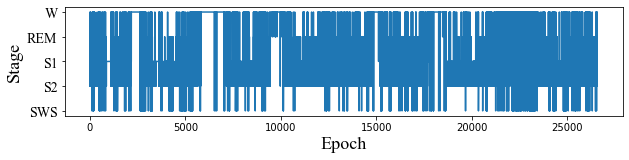

In [11]:
print(classification_report(y_pred=basline_pred, y_true=teY))
print(confusion_matrix(y_true=basline_pred, y_pred=teY))
print(cohen_kappa_score(basline_pred, teY))
Sleep_periodogram(basline_pred)

### Decision function smoothing

              precision    recall  f1-score   support

           0       0.39      0.09      0.14       346
           1       0.85      0.90      0.87      3330
           2       0.87      0.81      0.84      1100
           3       0.77      0.82      0.80      1584
           4       0.92      0.92      0.92      2497

    accuracy                           0.85      8857
   macro avg       0.76      0.71      0.71      8857
weighted avg       0.84      0.85      0.84      8857

[[  30  105    2  137   72]
 [   2 3008  132  134   54]
 [   0  179  888    1   32]
 [   4  224    0 1302   54]
 [  41   42    0  112 2302]]
0.7919758064623181


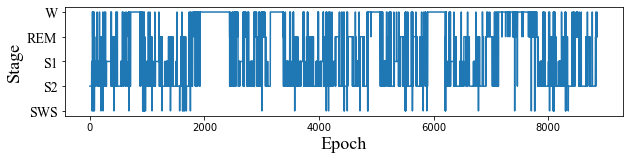

In [12]:
pred1, label , score = smoothing(estimator=estimator, score=score, n=n, label=teY)
print(classification_report(y_pred=pred1, y_true=label))
print(confusion_matrix(y_true=label, y_pred=pred1))
print(cohen_kappa_score(pred1, label))
Sleep_periodogram(pred1)

### Adaptive mode filter Smoothing

              precision    recall  f1-score   support

           0       0.35      0.05      0.09       346
           1       0.84      0.92      0.88      3330
           2       0.89      0.80      0.84      1100
           3       0.81      0.87      0.84      1584
           4       0.95      0.94      0.95      2497

    accuracy                           0.87      8857
   macro avg       0.77      0.72      0.72      8857
weighted avg       0.85      0.87      0.86      8857

[[  19  130    2  135   60]
 [   1 3072  101  124   32]
 [   0  214  877    0    9]
 [   1  192    0 1374   17]
 [  34   49    0   63 2351]]
0.8169471150346239


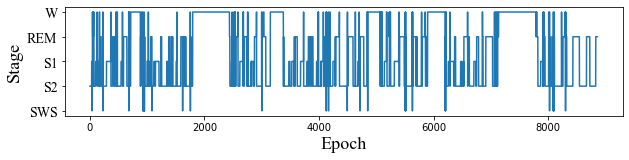

In [13]:
pred2 = smoothingII(pred1)
print(classification_report(y_pred=pred2, y_true=label))
print(confusion_matrix(y_true=label, y_pred=pred2))
print(cohen_kappa_score(pred2, label))
Sleep_periodogram(pred2)